In [19]:
import mariadb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from schema_creation import connection
import numpy as np

conn = connection(password='admin', database="vet_clinic")
cur = conn.cursor()

connected to @localhost on port 3306


# Przygotuj wykres przedstawiający liczbę wizyt każdego dnia

<AxesSubplot:>

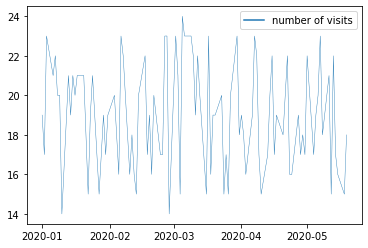

In [11]:
cur.execute('''select date(real_date), count(*) from visits where real_date is not null
group by year(real_date), month(real_date), day(real_date);
''')

records = cur.fetchall()
dates = []
novs = []
for date, nov in records:
    dates.append(date)
    novs.append(nov)

df = pd.DataFrame(data={'number of visits': novs}, index=dates)
sns.lineplot(data=df[:100], linewidth = 0.4)

# Przygotuj wykres przedstawiający bilans zysków i strat kliniki.

,number of visits
2020-01-01,19
2020-01-02,17
2020-01-03,23
2020-01-06,21
2020-01-07,22
...,...
2021-06-21,22
2021-06-22,22
2021-06-23,13
2021-06-24,20


# Stwórz listę zwierzaków najdłużej czekających na wizytę.

# rozkład wagi zwierząt

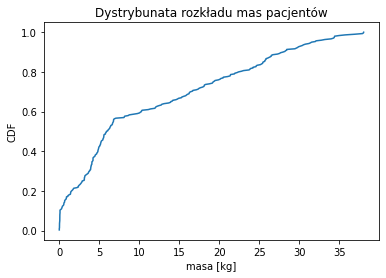

In [87]:

cur.execute('''select weight from pets;
''')

records = cur.fetchall()
data = [float(record[0]) for record in records]
n = len(data)
Cumsum = np.cumsum(np.ones((1,n))/n)

plt.plot(sorted(data), Cumsum)
plt.xlabel('masa [kg]')
plt.ylabel('CDF')
plt.title("Dystrybunata rozkładu mas pacjentów")
plt.show()


# zarobki lekarzy w stosunku do przychodów z wizyt

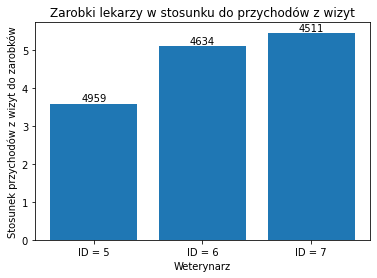

In [88]:
cur.execute('''select salary, employeeID from employees where position = 'Weterynarz';
''')

records1 = cur.fetchall()

cur.execute('''select employeeID, sum(cost) from visits where real_date is not null
group by employeeID, year(real_date), month(real_date) ;
''')
records2 = cur.fetchall()
records2 = [(item[0], int(item[1])) for item in records2]
df = pd.DataFrame(data={'vet': [item[0] for item in records2], 'sum': [item[1] for item in records2]})
df = df.groupby('vet').agg(np.mean).reset_index()
df['sum'] = df['sum']/[int(it[0]) for it in records1]

xdata = df['vet']
ydata = df['sum']
x_labels = [int(it[0]) for it in records1]

line = plt.bar(xdata, ydata)
plt.xlabel("Weterynarz")
plt.ylabel("Stosunek przychodów z wizyt do zarobków")

for i in range(len(ydata)):
    plt.annotate(x_labels[i], xy = (xdata[i], ydata[i]),ha='center', va = 'bottom')

plt.xticks(xdata,[f'ID = {it}' for it in xdata])
plt.title("Zarobki lekarzy w stosunku do przychodów z wizyt")
plt.show()

# najczęściej przepisywane leki

In [69]:
cur.execute('''select drugID, sum(amount), name from meds_prescribed left join meds using (drugID)
group by drugID order by sum(amount) desc limit 20 ;
''')
records = cur.fetchall()

pd.DataFrame(data = {'id': [it[0] for it in records], 'name': [it[2] for it in records], 'total quantity': [it[1] for it in records] })

,id,name,total quantity
0,87,oclacitinib – antipruritic,226.0
1,2,alprazolam,213.0
2,111,rifampin,212.0
3,118,sulfasalazine,211.0
4,57,isoxsuprine,210.0
5,6,amitraz,210.0
6,52,gentamicin/betamethasone valerate/clotrimazole,207.0
7,48,flumazenil,205.0
8,127,trimethoprim,204.0
9,21,cephalexin,204.0


# procentowy podział strat

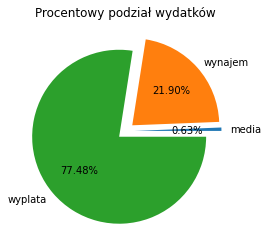

In [86]:
cur.execute('''select avg(x), type from (select sum(amount) as 'x', type from cash_flow where amount < 0 group by type, year(date), month(date)) as zzz group by type;
''')

records = cur.fetchall()

plt.pie([int(-1*it[0]) for it in records], labels=[it[1] for it in records],autopct='%0.2f%%', explode = [0.1,0.1,0.1])
plt.title("Procentowy podział wydatków")
plt.show()